# Setup

In [ ]:
import pickle as pk
import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.cluster import AgglomerativeClustering

In [2]:
def get_distances(metric_func, means, covs, batch_size = 128, **kwargs):
    num_samples = means.shape[0]
    batches = []
    for i in range(math.ceil(num_samples / batch_size)):
        print(f"{i*batch_size}/{num_samples}           ", end = "\r")
        source_i = torch.arange(i*batch_size, min((i+1)*batch_size, num_samples))
        dist = metric_func(means = means, covs = covs, source_i = source_i, 
                           target_i = torch.arange(num_samples)[None], **kwargs)
        batches.append(dist)
    print("")
    dist_matrix = torch.cat(batches)
    distances = (dist_matrix.T + dist_matrix) / 2
    return distances

def get_cov_distance(means, covs, num_steps, source_i, target_i, **kwargs):
    inv_covs = torch.linalg.inv(covs)
    (source_means, source_inv) = (means[source_i], inv_covs[source_i])
    (nn_means, nn_inv) = (means[target_i], inv_covs[target_i])
    diff_vectors = nn_means - source_means[:, None]
    steps = torch.linspace(0, 1, num_steps + 1)[1:]
    interp_invs = torch.einsum("s,nlij->snlij", 1 - steps, source_inv[:, None]) + torch.einsum(
        "s,nlij->snlij", steps, nn_inv
    )
    dist = torch.sqrt(torch.einsum("nli,snlij,nlj->snl", diff_vectors, interp_invs, diff_vectors)).mean(0)
    return dist

def get_euclidean_distance(means, source_i, target_i, **kwargs):
    diff_vectors = means[source_i, None] - means[target_i]
    dist = torch.linalg.norm(diff_vectors, dim=-1)
    return dist

def get_tree_labels(tree_children, num_samples, cluster_counts):
    parent_map = [((child_1, i), (child_2, i)) for (i, (child_1, child_2)) in enumerate(tree_children, num_samples)]
    cuml_indices = np.arange(num_samples)
    cluster_indices = {num_samples: cuml_indices.copy()} if num_samples in cluster_counts else {}
    for (merge, ((child_1, parent), (child_2, parent))) in enumerate(parent_map, 1):
        num_clusters = num_samples - merge
        cuml_indices[(cuml_indices == child_1) | (cuml_indices == child_2)] = parent
        if num_clusters in cluster_counts:
            cluster_map = {label: i for (i, label) in enumerate(np.unique(cuml_indices))}
            cluster_indices[num_clusters] = np.asarray([cluster_map[idx] for idx in cuml_indices])
    return cluster_indices

# Clustering

In [3]:
with open("../../het_reg_2d_one_sec_hemi_results.pkl", "rb") as target:
    data = pk.load(target)

In [4]:
n_samples = 20000

total_samples = data["xy"].shape[0]
idx = np.random.default_rng(42).choice(total_samples, n_samples, replace = False)
(pos, covs) = (data["xy"][idx], data["xy_cov_pred"][idx])

In [5]:
cov_interp_steps = 10
batch_size = 128

X = torch.from_numpy(pos).float()
covs_tensor = torch.from_numpy(covs).float()
print("Computing covariance distances...")
cov_distances = get_distances(get_cov_distance, X, covs_tensor, batch_size, num_steps = cov_interp_steps)
print("Computing Euclidean distances...")
eucl_distances = get_distances(get_euclidean_distance, X, torch.from_numpy(covs), batch_size)


Computing covariance distances...
19968/20000           
Computing Euclidean distances...
19968/20000           


In [8]:
cluster_counts = {2, 5, 10, 20, 50}
link = "complete"

print("Clustering with covariance distances...")
cov_tree = AgglomerativeClustering(metric="precomputed", linkage=link).fit(cov_distances).children_
print("Clustering with Euclidean distances...")
eucl_tree = AgglomerativeClustering(metric="precomputed", linkage=link).fit(eucl_distances).children_
print("Computing covariance cluster labels...")
cov_clusters = get_tree_labels(cov_tree, n_samples, cluster_counts)
print("Computing Euclidean cluster labels...")
eucl_clusters = get_tree_labels(eucl_tree, n_samples, cluster_counts)


Clustering with covariance distances...
Clustering with Euclidean distances...
Computing covariance cluster labels...
Computing Euclidean cluster labels...


# Plots

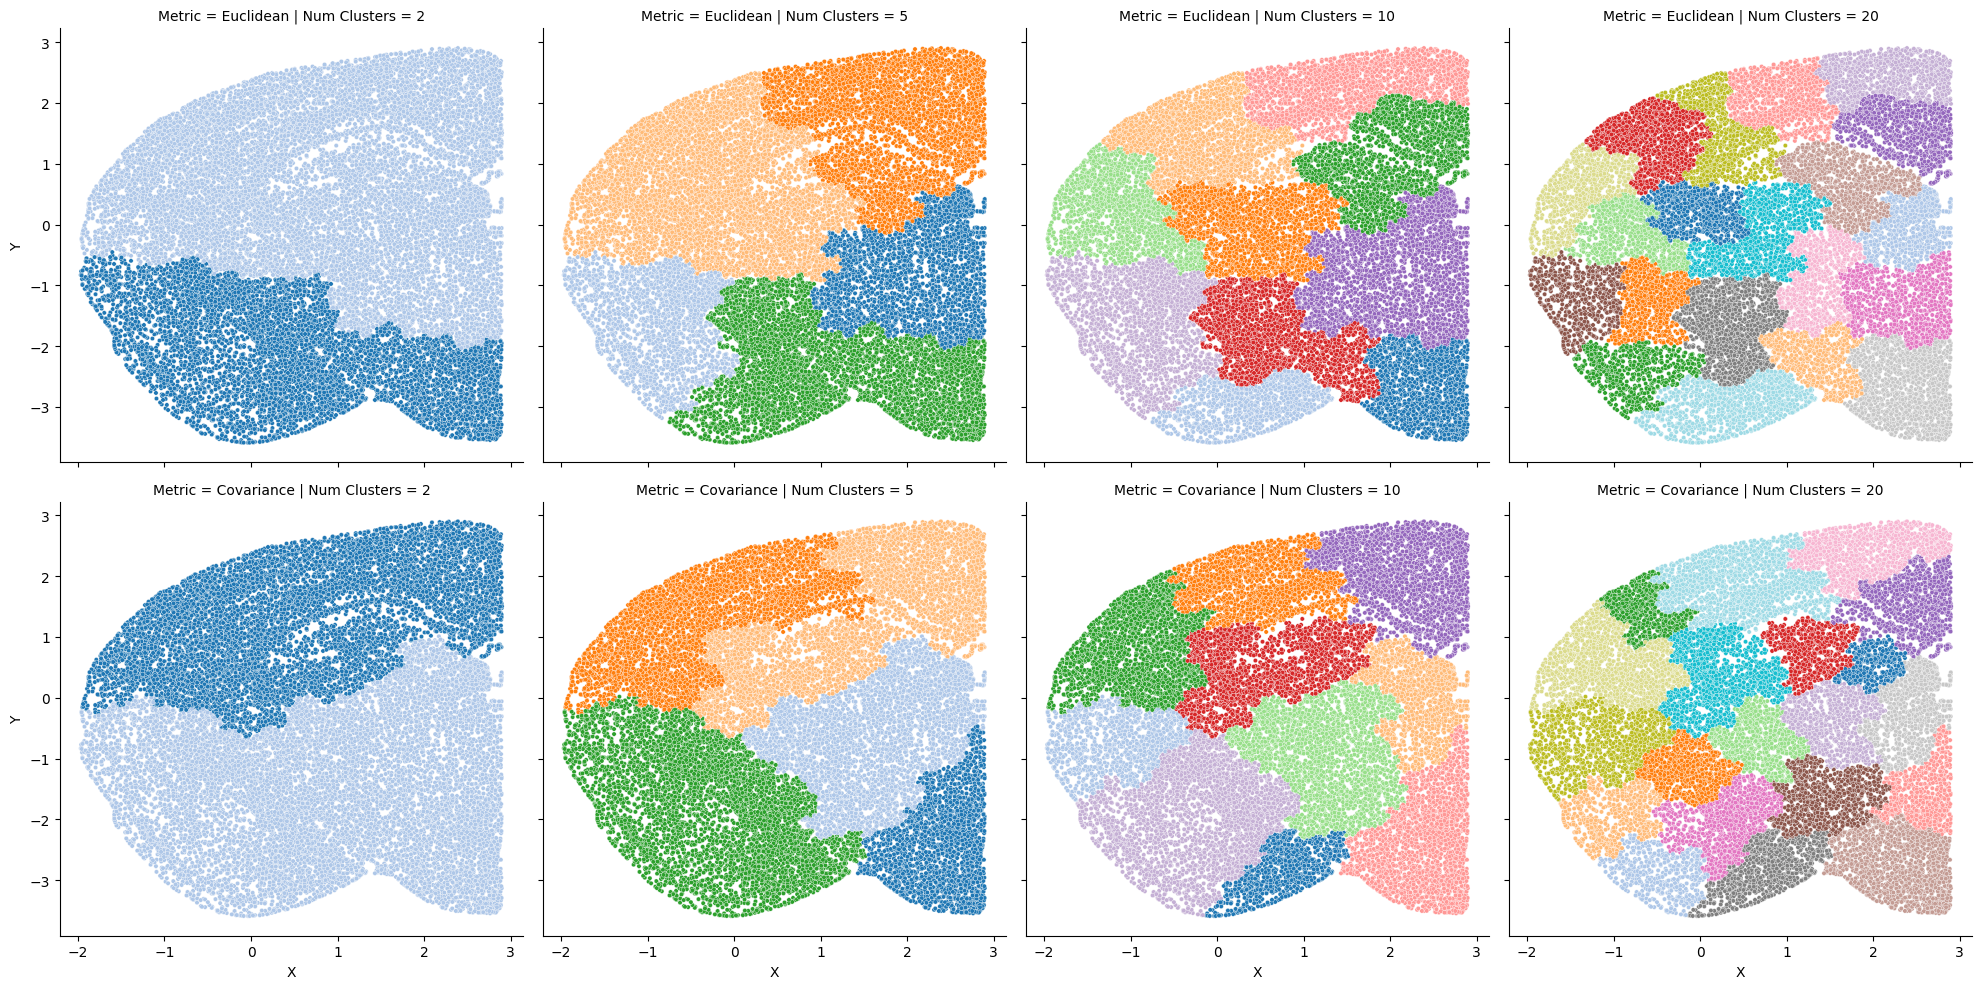

In [9]:
plot_clusters = [2, 5, 10, 20]
plot_data = {"X": [], "Y": [], "Num Clusters": [], "Metric": [], "Cluster": []}
for k in plot_clusters:
    for (metric, clusters) in zip(["Euclidean", "Covariance"], [eucl_clusters[k], cov_clusters[k]]):
        plot_data["X"].extend(pos[:, 0])
        plot_data["Y"].extend(-pos[:, 1])
        plot_data["Num Clusters"].extend(n_samples * [k])
        plot_data["Metric"].extend(n_samples * [metric])
        plot_data["Cluster"].extend(clusters.tolist())
plot = sns.relplot(plot_data, x="X", y="Y", hue="Cluster", row="Metric", col="Num Clusters", s=10, palette="tab20")
plot._legend.remove()
plt.show()